# <a id='toc1_'></a>[GSU Data Challenge](#toc0_)

Authors:

| Nom | Prenom | ID |
| -------- | ----- | -------- |
| Yurdakul | Bengü | 19401851 |
| Şengül | Beste | 19401831 |
| Erdi | Furkan | 21401966 |

**İçindekiler**<a id='toc0_'></a>    
- [GSU Data Challenge](#toc1_)    
  - [1. Importing Libraries](#toc1_1_)    
  - [2. Importing Data](#toc1_2_)    
  - [3. Data Preprocessing](#toc1_3_)    
  - [4. Analyizing](#toc1_4_)    
  - [5. Splitting Data to Test and Train the Model](#toc1_5_)    
  - [6. Train the Model](#toc1_6_)    
    - [6.1. Product Based Estimation By ARIMA](#toc1_6_1_)    
    - [6.2 By Random Forest Regressor](#toc1_6_2_)    
    - [6.3. LSTM Method](#toc1_6_3_)    
      - [!!! WILL BE EDITED](#toc1_6_3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[1. Importing Libraries](#toc0_)

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',1000)

## <a id='toc1_2_'></a>[2. Importing Data](#toc0_)

In [ ]:
file_path = 'data.xlsx'

df = pd.read_excel(file_path)

df.head()

## <a id='toc1_3_'></a>[3. Data Preprocessing](#toc0_)

In [ ]:
# Filter rows where 'Miktar' is greater than 0
df = df[df['Miktar'] > 0]

replacements_for_kategori_adi = {
    'Alkollü İçecekler Grubu': 'Alkollü İçecek Grubu',
    'Alkolsüz İçecekler Grubu': 'Alkolsüz İçecek Grubu',
    'TA_Ticari Market Ürün Grubu': 'TA-Ticari Market Ürün Grubu',
    'Pizza grubu': 'Pizza Grubu',
    'Salata grubu': 'Salata Grubu',
    'Tatlı grubu': 'Tatlı Grubu',
    'Snack Grubu': 'Atıştırmalıklar'
}

# Replace the values in the 'KategoriAdı' column
df['KategoriAdı'] = df['KategoriAdı'].replace(replacements_for_kategori_adi)

# Define the replacements
replacements_for_alt_kategori_adi = {
    'Açik Içecekler': 'Açık İçecekler',
    'Balık Salata': 'Balıklı Salata',
    'Kasaönü': 'Kasa Önü',
    'Sandviç': 'Sandviçler'
}

# Replace the values in the 'AltKategoriAdi' column
df['AltKategoriAdi'] = df['AltKategoriAdi'].replace(replacements_for_alt_kategori_adi)

# Convert 'Tarih' column to datetime
df['Tarih'] = pd.to_datetime(df['Tarih'])

# Convert 'FaturaNo' column to integer
df['FaturaNo'] = df['FaturaNo'].astype(int)

# Convert 'Miktar' column to float
df['Miktar'] = df['Miktar'].astype(float)

# Create mappings for 'Birim', 'KategoriAdı', 'AltKategoriAdi', and 'MagazaKodu'
birim_mapping = {'ADET': 1, 'PORS': 2, 'DILIM': 3} # Adet -> 0.10 luk üs, # Dilim -> Integer, # Pors -> 0.5'lik üs
kategori_mapping = {kategori: i+1 for i, kategori in enumerate(df['KategoriAdı'].unique())}
alt_kategori_mapping = {alt_kategori: i+1 for i, alt_kategori in enumerate(df['AltKategoriAdi'].unique())}
magaza_mapping = {'A1': 1, 'B1': 2, 'B2': 3, 'C2': 4, 'C3': 5, 'D3': 6}

# Create new dataframes for mappings
birim_df = pd.DataFrame(list(birim_mapping.items()), columns=['Birim', 'Birim_ID'])
kategori_df = pd.DataFrame(list(kategori_mapping.items()), columns=['KategoriAdı', 'Kategori_ID'])
alt_kategori_df = pd.DataFrame(list(alt_kategori_mapping.items()), columns=['AltKategoriAdi', 'AltKategori_ID'])
magaza_df = pd.DataFrame(list(magaza_mapping.items()), columns=['MagazaKodu', 'Magaza_ID'])

birim_df.to_pickle("kodlar/birim.pkl")
kategori_df.to_pickle("kodlar/kategori.pkl")
alt_kategori_df.to_pickle("kodlar/alt_kategori.pkl")
magaza_df.to_pickle("kodlar/magaza.pkl")

# Apply mappings to respective columns
df['Birim'] = df['Birim'].map(birim_mapping)
df['KategoriAdı'] = df['KategoriAdı'].map(kategori_mapping)
df['AltKategoriAdi'] = df['AltKategoriAdi'].map(alt_kategori_mapping)
df['MagazaKodu'] = df['MagazaKodu'].map(magaza_mapping)

# Sum the faturas by other values 
df = df.groupby(df.columns.difference(['FaturaNo']).tolist(), as_index=False).agg({'Miktar': 'sum'})

# Sort the dataframe by Tarih and ÜrünKodu
df = df.sort_values(by=['Tarih', 'ÜrünKodu'])

In [ ]:
df.to_pickle("preprocessed_data.pkl")

df

,AltKategoriAdi,Birim,KategoriAdı,MagazaKodu,Tarih,ÜrünKodu,Miktar
167229,50,1,21,1,2023-01-01,30.101.0079,1.0
167230,50,1,21,1,2023-01-01,30.101.0301,1.0
169961,50,2,21,1,2023-01-01,30.101.0540,1.0
347594,105,2,17,1,2023-01-01,30.101.0604,1.0
380825,115,2,2,2,2023-01-01,30.101.0605,2.0
...,...,...,...,...,...,...,...
184740,60,1,15,6,2023-11-30,30.304.0197,1.0
101884,29,1,15,4,2023-11-30,30.305.0102,2.0
102583,29,1,15,4,2023-11-30,30.305.0117,3.0
101885,29,1,15,4,2023-11-30,30.305.0118,1.0


## <a id='toc1_4_'></a>[4. Analyizing](#toc0_)

In [ ]:
profile = ProfileReport(df, title="GSU Data Challenge - TAV Data Profiling Report")

profile

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# Group by MagazaKodu and iterate over each group
for magaza_kodu, group_df in df.groupby('MagazaKodu'):
    print(f"Summary statistics for Magaza {magaza_df.loc[magaza_df['Magaza_ID'] == magaza_kodu, 'MagazaKodu'].iloc[0]}:\n")
    print(group_df.head())
    print()
    print(group_df.describe())
    print()
    print("##############################################################################################################")

## <a id='toc1_5_'></a>[5. Splitting Data to Test and Train the Model](#toc0_)

In [ ]:
# Sort the DataFrame by 'Tarih' and then by 'ÜrünKodu'
df_sorted = df.sort_values(by=['Tarih'])

split_date = "2023-10-30"

# Split the DataFrame into train and test sets
train_df = df_sorted[df_sorted['Tarih'] <= split_date]
train_df = train_df.sort_values(by=['Tarih', "ÜrünKodu"])

test_df = df_sorted[df_sorted['Tarih'] > split_date]
test_df = test_df.sort_values(by=['Tarih', "ÜrünKodu"])

train_df.to_pickle("train_data.pkl")
test_df.to_pickle("test_data.pkl")

# Display the shapes of train and test DataFrames
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

## <a id='toc1_6_'></a>[6. Train the Model](#toc0_)

### <a id='toc1_6_1_'></a>[6.1. Product Based Estimation By ARIMA](#toc0_)

In [114]:
from statsmodels.tsa.arima.model import ARIMA

In [115]:
def custom_round(row):
    if row['Birim'] == 1:
        return round(row['Miktar'] * 10) / 10
    elif row["Birim"] == 2:
        return int(row['Miktar'])
    else:
        return round(row['Miktar'] * 2) / 2

In [116]:
df_arima = pd.read_pickle("preprocessed_data.pkl")

In [137]:
def estimate_future_value(df, product_id, store_id):
    # Filter data for the current product
    product_data = df[ ( df['ÜrünKodu'] == product_id ) & ( df["MagazaKodu"] == store_id )]

    before_data = product_data[["Tarih", "Miktar", "Birim"]]

    if product_data.empty:
        return "This store is not selling the product"
    # Split the data into training and testing sets
    train_size = int(len(product_data) * 0.8)
    train, test = product_data[:train_size], product_data[train_size:]
    
    # Fit an ARIMA model
    model = ARIMA(train['Miktar'], order=(5,1,0)) # Example order, you may need to tune this
    model_fit = model.fit()
    
    # Optionally, forecast future sales
    future_steps = 10 # Example number of steps to forecast
    future_forecast = model_fit.forecast(steps=future_steps)
    
    # Generate date range for forecast
    last_date = product_data['Tarih'].max()
    forecast_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='D')[1:] # Start from the day after the last date
    
    # Create DataFrame for forecasted values with dates
    forecast_df = pd.DataFrame({'Tarih': forecast_dates, 'Miktar': future_forecast, 'Birim': product_data.iloc[0]["Birim"]})

    forecast_df["Miktar"] = forecast_df.apply(custom_round, axis=1)
    
    result_df = pd.concat([before_data, forecast_df], axis=False)
    result_df.reset_index(drop=True, inplace=True)

    print('Forecast for Product', product_id)
    print(result_df)

    plt.figure(figsize=(18, 6))

    # Plot the dataframe
    plt.plot(result_df['Tarih'], result_df['Miktar'])

    # Add labels and title
    plt.xlabel('Tarih')
    plt.ylabel('Miktar')
    plt.title(f'{product_id} Ürününün ARIMA ile Gelecek Değer Tahminleri')

    # Add padding to top and bottom
    plt.ylim(result_df['Miktar'].min() - 5, result_df['Miktar'].max() + 5)

    plt.grid(True)

    # Show the plot
    plt.show()

    return result_df

Forecast for Product 30.511.0090
        Tarih  Miktar  Birim
0  2023-11-16     1.0      1
1  2023-11-17     1.0      1
2  2023-11-19     2.0      1
3  2023-11-25     2.0      1
4  2023-11-26     1.0      1
5  2023-11-28     2.0      1
6  2023-11-30     1.0      1
7  2023-12-01     1.0      1
8  2023-12-02     2.0      1
9  2023-12-03     2.0      1
10 2023-12-04     1.0      1
11 2023-12-05     1.0      1
12 2023-12-06     2.0      1
13 2023-12-07     2.0      1
14 2023-12-08     1.0      1
15 2023-12-09     1.0      1
16 2023-12-10     2.0      1


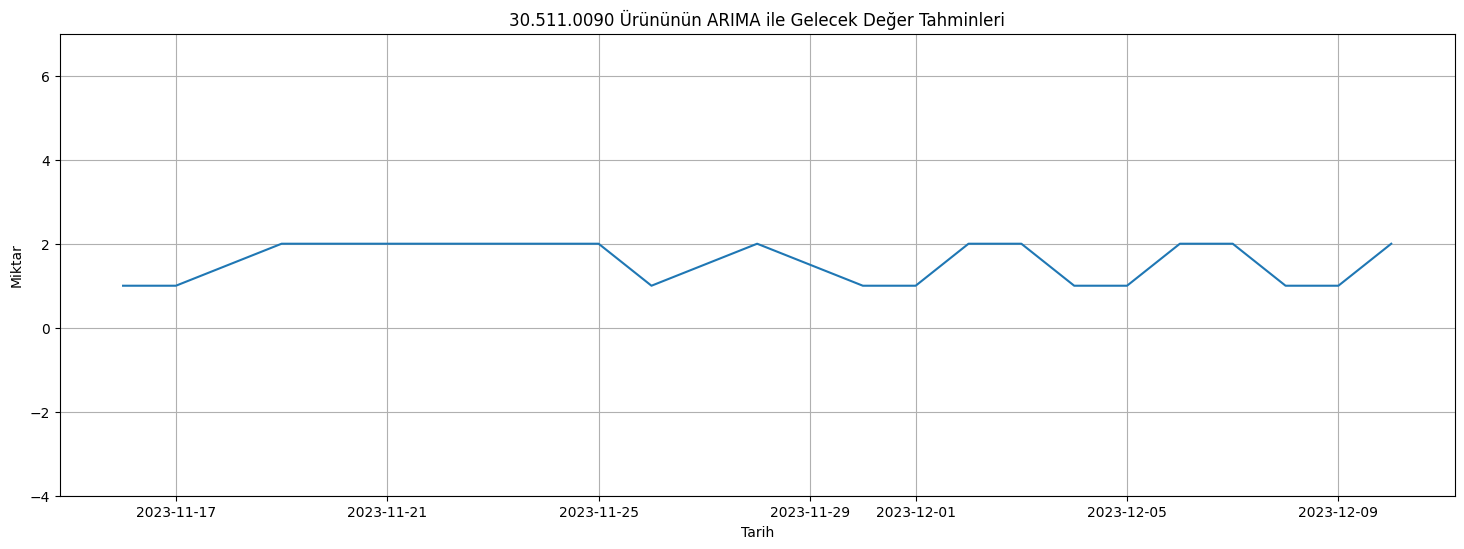

,Tarih,Miktar,Birim
0,2023-11-16,1.0,1
1,2023-11-17,1.0,1
2,2023-11-19,2.0,1
3,2023-11-25,2.0,1
4,2023-11-26,1.0,1
5,2023-11-28,2.0,1
6,2023-11-30,1.0,1
7,2023-12-01,1.0,1
8,2023-12-02,2.0,1
9,2023-12-03,2.0,1


In [138]:
estimate_future_value(df_arima, product_id="30.511.0090", store_id=5)

### <a id='toc1_6_2_'></a>[6.2 By Random Forest Regressor](#toc0_)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector

In [ ]:
df_rfr = pd.read_pickle("preprocessed_data.pkl")

In [ ]:
# Convert categorical columns to numerical using one-hot encoding
df_rfr = pd.get_dummies(df_rfr, columns=['AltKategoriAdi', 'Birim', 'KategoriAdı', 'MagazaKodu'], dtype=np.int64)

df_rfr["Tarih"] = df_rfr["Tarih"].apply(lambda x: x.toordinal()).astype('float64')

In [ ]:
df_rfr2 = df_rfr.copy()

# Split features and target variable
X = df_rfr2.drop(['ÜrünKodu', 'Miktar'], axis=1)
y = df_rfr2['Miktar']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Model Selection and Training
random_forest_regressor_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the model
random_forest_regressor_model.fit(X_train, y_train)

# Make predictions
y_pred = random_forest_regressor_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 93.41005637521121


In [ ]:
print(y_pred)

[ 1.01        1.192       8.4358373  ... 12.48452936  2.15766066
  3.21564011]


### <a id='toc1_6_3_'></a>[6.3. LSTM Method](#toc0_)

#### <a id='toc1_6_3_1_'></a>[!!! WILL BE EDITED](#toc0_)

In [97]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [39]:
df_lstm = pd.read_pickle("preprocessed_data.pkl")

In [111]:
def estimate_future_value(df, product_id):
    # Filter data for the current product
    product_data = df[df['ÜrünKodu'] == product_id ]
    
    product_data.drop(columns=['ÜrünKodu'], inplace=True)
    product_data.set_index('Tarih', inplace=True)
    product_data.index.name = 'date'
    values = product_data.values

    print(values)

    # integer encode direction
    encoder = LabelEncoder()
    values[:,0] = encoder.fit_transform(values[:,0])
    values[:,1] = encoder.fit_transform(values[:,1])
    values[:,2] = encoder.fit_transform(values[:,2])
    values[:,3] = encoder.fit_transform(values[:,3])
    # ensure all data is float
    values = values.astype('float32')

    print(values)

    # normalize features
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    # reframed.drop(reframed.columns[[0, 1, 2, 3, 5, 6, 7, 8, 9]], axis=1, inplace=True)
    print(reframed.head())

    # split into train and test sets
    values = reframed.values
    n_train_hours = 365 * 24
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = pd.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = pd.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = pd.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)

In [ ]:
estimate_future_value(df = df_lstm, product_id="30.105.0612")